# NEWEST FROM HERE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier # Load k-NN from sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import datetime as dt


from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix

import collections
from statsmodels.distributions.empirical_distribution import ECDF

import unittest

from mesa.time import RandomActivation, SimultaneousActivation, BaseScheduler
from mesa.datacollection import DataCollector
from mesa import Model, Agent
from mesa.batchrunner import BatchRunner

import xgboost as xgb

from sklearn.svm import SVC, LinearSVC
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from category_encoders.binary import BinaryEncoder
from itertools import combinations


In [2]:
def get_auc(y, y_pred_probabilities, class_labels, column =1, plot = True):
    fpr, tpr, _ = roc_curve(y == column, y_pred_probabilities[:,column])
    roc_auc = roc_auc_score(y_true=y, y_score=y_pred_probabilities[:,1])
    print ("AUC: ", roc_auc)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## Loading and merging data frames

In [3]:
severity_scores_df = pd.read_csv('severity_scores_df.csv')
severity_scores_df=severity_scores_df.drop_duplicates(subset='subject_id',keep='first').sort_values(by='subject_id')

# Removing redundant columns Subject_ID and HADM_ID
severity_scores_df = severity_scores_df.drop(['subject_id','hadm_id','icustay_expire_flag','ICUSTAY_AGE_GROUP',
                                              'OASIS', 'OASIS_PROB','age_score','preiculos_score', 'gcs_score',
                                                'heartrate_score', 'meanbp_score',
                                               'resprate_score', 'temp_score',
                                               'UrineOutput_score', 'mechvent_score',
                                               'electivesurgery_score', 'SAPS', 'resp_score', 'vent_score',
                                               'hematocrit_score', 'glucose_score', 'SAPSII', 'SAPSII_PROB',
                                               'PaO2FiO2_score', 'bilirubin_score', 'comorbidity_score',
                                               'admissiontype_score', 'SOFA','INTIME','age'], axis=1)

In [4]:
main_df2 = pd.read_csv("main_df2.csv")

# Remove duplicate 'DEATHRATE_INT_CAT__' columns
main_df2 = main_df2.drop(['DEATHRATE_INT_CAT__1.0_x', 'DEATHRATE_INT_CAT__2.0_x'],axis=1)
main_df2 = main_df2.rename({'DEATHRATE_INT_CAT__1.0_y':'DEATHRATE_INT_CAT__1.0',
                            'DEATHRATE_INT_CAT__2.0_y':'DEATHRATE_INT_CAT__2.0'},axis=1)

In [5]:
df = main_df2.merge(severity_scores_df, how='left', left_on = 'ICUSTAY_ID' ,right_on='icustay_id')

vitals_df = pd.read_csv("vitals_df.csv")
df = df.merge(vitals_df, how='inner', on='icustay_id')

## Encoding dummy variables

In [6]:
# Binary Encoding

diagnosis_encoder = BinaryEncoder()
diagnosis_binary = diagnosis_encoder.fit_transform(df['ICD9_CODE'].astype(str))

# Create dummies for Gender
gender_df =pd.get_dummies(df ['GENDER'],prefix='gender_', drop_first=True)

# Create dummies for Age Group
age_group_df =pd.get_dummies(df ['ICUSTAY_AGE_GROUP'], prefix='age_group_', drop_first=True)

# Create dummies for Admission Type
admtype_df =pd.get_dummies(df ['ADMISSION_TYPE'],prefix='ADMISSION_TYPE_', drop_first=True)

# Create dummies for Insurance Type
instype_df =pd.get_dummies(df ['INSURANCE'],prefix='INSURANCE_TYPE_', drop_first=True)

# Creat dummies for car_unit
care_unit = pd.get_dummies(df ['CURR_CAREUNIT'], prefix='careunit_', drop_first=True)

# Merge all encoded variables
df2 = pd.concat([df,gender_df,age_group_df,admtype_df,instype_df,care_unit], axis=1) #, diagnosis_binary


## Reformatting Time Variables

In [7]:
# Dealing with time variables

df2['OUTTIME'] = pd.to_datetime(df2['OUTTIME'],format='%Y-%m-%d')
df2['INTIME'] = pd.to_datetime(df2['INTIME'],format='%Y-%m-%d')
# df2['DOB'] = pd.to_datetime(df2['DOB'],format='%Y-%m-%d')

# Shift timescale
df2['INTIME_ACTUAL']= df2['INTIME']+ pd.to_timedelta(df2['DIFF'],unit='D')
df2['OUTTIME_ACTUAL']= df2['OUTTIME']+ pd.to_timedelta(df2['DIFF'],unit='D')
# df2['DOB_ACTUAL']= df2['DOB']+ pd.to_timedelta(df2['DIFF'],unit='D')

In [8]:
df3 = df2.drop(['icustay_id', 'hospital_expire_flag',
               'ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME', 'OUTTIME', 'DIFF',
               'LAST_WARDID', 'GENDER','DOB', 'ICD9_CODE', 'SHORT_TITLE',
               'LONG_TITLE', 'SEQ_NUM', 'DEATHTIME','ICUSTAY_AGE_GROUP',
               'INTIME_ACTUAL','OUTTIME_ACTUAL',"ADMISSION_TYPE",'INSURANCE','CURR_CAREUNIT'], axis=1)

df2 (before key information is dropped) will be used for later analyses

# Mortality Basic Model (??)

In [9]:
# Prepare variables for model
y=df3['HOSPITAL_EXPIRE_FLAG']
X=df3.drop(['HOSPITAL_EXPIRE_FLAG'],axis=1)

# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
orig_index = X_train.index

In [11]:
imp_iter = IterativeImputer(random_state=0)
imp_iter.fit(X_train)
X_train = imp_iter.transform(X_train)

In [12]:
X_train = pd.DataFrame(X_train)
X_train.columns = df3.drop(['HOSPITAL_EXPIRE_FLAG'],axis=1).columns

In [13]:
X_train.index = orig_index

In [14]:
X_test = imp_iter.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = df3.drop(['HOSPITAL_EXPIRE_FLAG'],axis=1).columns

In [15]:
# Remove some entries of class 0
import random
index_0 = [i for i in y_train[y_train == 0].index]
index_1 = [i for i in y_train[y_train == 1].index]
samp = random.sample(index_0, len(index_1))
samp.extend(index_1)
X_train = X_train.loc[samp,]
y_train = y_train.loc[samp,]

In [16]:
# Choose columns to be scaled for X_train
scale_columns = ['age','preiculos', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp',
       'urineoutput', 'respiration',
       'coagulation', 'liver', 'cardiovascular', 'cns', 'renal'] #,'DAYS_FROM_ADMISSION'
scale_df = X_train[scale_columns]

# Seperate the non-scaled columns (dummies) X_train
temp = X_train.drop(scale_columns,axis=1)
temp = temp.reset_index(drop=True)

# Apply actual scaling to X_train
scaler = preprocessing.StandardScaler().fit(scale_df) 
scale_tr = scaler.transform(scale_df) 
scale_df = pd.DataFrame(scale_tr,columns=scale_columns)

# Add the non-scaled and scaled dataframes back together
X_train = pd.concat([scale_df,temp], axis=1) 

#Choose columns to be scaled for X_test
scale_df2 = X_test[scale_columns]

# Seperate the non-scaled columns (dummies) X_test
temp2 = X_test.drop(scale_columns,axis=1)
temp2 = temp2.reset_index(drop=True)

# Apply actual scaling to X_test
# scaler2 = preprocessing.StandardScaler().fit(scale_df2) 
scale_tr2= scaler.transform(scale_df2) 
scale_df2=pd.DataFrame(scale_tr2,columns=scale_columns)

# Add the non-scaled and scaled dataframes back together X_test
X_test = pd.concat([scale_df2,temp2], axis=1) 

In [17]:
#Applying Lasso
model_lasso = LassoCV(alphas=[1,0.1,0.01,0.0005]).fit(X_train, y_train) #variating through different alphas
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
#y_pred_lasso = model_lasso.predict(X_test)

/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2577387786195686, tolerance: 0.0458
  tol, rng, random, positive)


In [18]:
df_coefs= coef

In [19]:
df_coefs.sort_values(ascending=True)

age_group__>89              -0.183288
careunit__CSRU              -0.075110
gcs                         -0.059586
urineoutput                 -0.048285
gender__M                   -0.022819
                               ...   
careunit__SICU               0.136986
age_group__65-89             0.155919
mechvent                     0.165017
DEATHRATE_CAT__2.0           0.175123
ADMISSION_TYPE__EMERGENCY    0.222593
Length: 61, dtype: float64

In [20]:
#df5 = df5.drop(['DOB_ACTUAL','INTIME_ACTUAL','INTIME','OUTTIME','DOB','DOD','CHARTTIME','ICUSTAY_ID','SUBJECT_ID','HADM_ID','Diff','LAST_WARDID','GENDER','WARNING'], axis=1)

In [21]:
# IMPORTANT!!!!
# But one-hot encoding also presents two problems that are more particular to tree-based models:
# The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
# A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.

feature_names = X_train.columns
forest = RandomForestClassifier(n_estimators=20)  #Setting n_estimator to prevent overfitting
forest_fitted = forest.fit(X_train, y_train) 
scores = cross_val_score(forest, X_train, y_train, cv=5)
y_pred_forest = forest.predict(X_test)
y_pred_prob = forest.predict_proba(X_test)

In [22]:
# Step 5: Assess expected accuracy
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Step 6: Assess variable importance
importances = forest_fitted.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.83 (+/- 0.03)


DEATHRATE_CAT__2.0          1.000000
DEATHRATE_CAT__1.0          0.877121
LOS                         0.702749
SysBP_Min                   0.634665
urineoutput                 0.583977
                              ...   
careunit__TSICU             0.026193
age_group__>89              0.021392
ADMISSION_TYPE__URGENT      0.003459
INSURANCE_TYPE__Self Pay    0.003186
DEATHRATE_INT_CAT__2.0      0.002902
Length: 61, dtype: float64

# LOS Basic Model

In [23]:
df_LOS = df3.drop('HOSPITAL_EXPIRE_FLAG',axis=1)

In [24]:
# Prepare variables for model
y=df_LOS['LOS']
X=df_LOS.drop(['LOS'],axis=1)

# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [25]:
orig_index = X_train.index

In [26]:
imp_iter = IterativeImputer(random_state=0)
imp_iter.fit(X_train)
X_train = imp_iter.transform(X_train)

In [27]:
X_train = pd.DataFrame(X_train)
X_train.columns = df_LOS.drop(['LOS'],axis=1).columns

In [28]:
X_train.index = orig_index

In [29]:
X_test = imp_iter.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = df_LOS.drop(['LOS'],axis=1).columns

In [30]:
# Choose columns to be scaled for X_train
scale_columns = ['age','preiculos', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp',
       'urineoutput', 'respiration',
       'coagulation', 'liver', 'cardiovascular', 'cns', 'renal'] #,'DAYS_FROM_ADMISSION'
scale_df = X_train[scale_columns]

# Seperate the non-scaled columns (dummies) X_train
temp = X_train.drop(scale_columns,axis=1)
temp = temp.reset_index(drop=True)

# Apply actual scaling to X_train
scaler = preprocessing.StandardScaler().fit(scale_df) 
scale_tr = scaler.transform(scale_df) 
scale_df = pd.DataFrame(scale_tr,columns=scale_columns)

# Add the non-scaled and scaled dataframes back together
X_train = pd.concat([scale_df,temp], axis=1) 

#Choose columns to be scaled for X_test
scale_df2 = X_test[scale_columns]

# Seperate the non-scaled columns (dummies) X_test
temp2 = X_test.drop(scale_columns,axis=1)
temp2 = temp2.reset_index(drop=True)

# Apply actual scaling to X_test
# scaler2 = preprocessing.StandardScaler().fit(scale_df2) 
scale_tr2= scaler.transform(scale_df2) 
scale_df2=pd.DataFrame(scale_tr2,columns=scale_columns)

# Add the non-scaled and scaled dataframes back together X_test
X_test = pd.concat([scale_df2,temp2], axis=1) 

In [31]:
#Applying Lasso
model_lasso = LassoCV(alphas=[1,0.1,0.01,0.0005]).fit(X_train, y_train) #variating through different alphas
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
#y_pred_lasso = model_lasso.predict(X_test)

/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [32]:
df_coefs= coef

In [33]:
df_coefs.sort_values(ascending=True)

careunit__CSRU              -3.190885e-01
DiasBP_Mean                 -8.047368e-02
HeartRate_Mean              -5.405499e-02
age                         -5.231764e-02
gcs                         -3.389129e-02
SysBP_Mean                  -1.745007e-02
MeanBP_Min                  -1.565050e-02
SysBP_Min                   -9.076468e-03
MeanBP_Max                  -2.823552e-03
Glucose_Min                 -1.681561e-03
RespRate_Min                -6.156625e-05
subject_id                  -6.686848e-06
ADMISSION_TYPE__URGENT       0.000000e+00
careunit__MICU              -0.000000e+00
INSURANCE_TYPE__Self Pay    -0.000000e+00
INSURANCE_TYPE__Private     -0.000000e+00
RespRate_Max                -0.000000e+00
TempC_Min                   -0.000000e+00
TempC_Mean                   0.000000e+00
SpO2_Max                    -0.000000e+00
INSURANCE_TYPE__Medicare     0.000000e+00
age_group__40-64             0.000000e+00
age_group__65-89             0.000000e+00
age_group__>89              -0.000

In [34]:
#df5 = df5.drop(['DOB_ACTUAL','INTIME_ACTUAL','INTIME','OUTTIME','DOB','DOD','CHARTTIME','ICUSTAY_ID','SUBJECT_ID','HADM_ID','Diff','LAST_WARDID','GENDER','WARNING'], axis=1)

In [35]:
# IMPORTANT!!!!
# But one-hot encoding also presents two problems that are more particular to tree-based models:
# The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
# A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.

feature_names = X_train.columns
forest = RandomForestRegressor(n_estimators=20)  #Setting n_estimator to prevent overfitting
forest_fitted = forest.fit(X_train, y_train) 
scores = cross_val_score(forest, X_train, y_train, cv=5, scoring='r2')
y_pred_forest = forest.predict(X_test)

In [36]:
# Step 5: Assess expected accuracy
print("R2 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Step 6: Assess variable importance
importances = forest_fitted.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

R2 Score: 0.12 (+/- 0.09)


mechvent                     1.000000
urineoutput                  0.653505
RespRate_Mean                0.650406
DEATHRATE_CAT__1.0           0.638843
Glucose_Min                  0.430210
subject_id                   0.424644
HeartRate_Max                0.416856
Glucose_Max                  0.407509
liver                        0.397903
cardiovascular               0.383089
hadm_id                      0.361387
SpO2_Mean                    0.340242
Glucose_Mean                 0.325731
DiasBP_Mean                  0.321939
TempC_Max                    0.314150
age                          0.307847
HeartRate_Mean               0.299760
SysBP_Mean                   0.285916
preiculos                    0.284322
respiration                  0.278228
TempC_Mean                   0.277735
HeartRate_Min                0.273690
heartrate                    0.265874
SpO2_Min                     0.260975
SysBP_Max                    0.255541
careunit__CSRU               0.253523
SysBP_Min   

# ABM

## Daily snapshots

In [37]:
# Only takes the first three characters from ICD9_Code as the rest is only decimal points 
#(https://mimic.physionet.org/mimictables/diagnoses_icd/)
df2['ICD9_CODE'] = df2['ICD9_CODE'].apply(lambda x: x[:3])
# Converts ICD9 Codes of type "O" to integer in case string contains only digits, else None
df2['ICD9_CODE'] = df2['ICD9_CODE'].apply(lambda x: int(x) if str(x).isdigit() else None)

def f(x):
    if x['ICD9_CODE'] > 1 and x['ICD9_CODE'] < 139: return 'Infectious And Parasitic Diseases'
    elif x['ICD9_CODE'] > 140 and x['ICD9_CODE'] < 239: return 'Neoplasms'
    elif x['ICD9_CODE'] > 240 and x['ICD9_CODE'] < 279: return 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders'
    elif x['ICD9_CODE'] > 280 and x['ICD9_CODE'] < 289: return 'Diseases Of The Blood And Blood-Forming Organs'
    elif x['ICD9_CODE'] > 290 and x['ICD9_CODE'] < 319: return 'Mental Disorders'
    elif x['ICD9_CODE'] > 320 and x['ICD9_CODE'] < 389: return 'Diseases Of The Nervous System And Sense Organs'
    elif x['ICD9_CODE'] > 390 and x['ICD9_CODE'] < 459: return 'Diseases Of The Circulatory System'
    elif x['ICD9_CODE'] > 460 and x['ICD9_CODE'] < 519: return 'Diseases Of The Respiratory System'
    elif x['ICD9_CODE'] > 520 and x['ICD9_CODE'] < 579: return 'Diseases Of The Digestive System'
    elif x['ICD9_CODE'] > 580 and x['ICD9_CODE'] < 629: return 'Diseases Of The Genitourinary System'
    elif x['ICD9_CODE'] > 630 and x['ICD9_CODE'] < 679: return 'Complications Of Pregnancy, Childbirth, And The Puerperium'
    elif x['ICD9_CODE'] > 680 and x['ICD9_CODE'] < 709: return 'Diseases Of The Skin And Subcutaneous Tissue'
    elif x['ICD9_CODE'] > 710 and x['ICD9_CODE'] < 739: return 'Diseases Of The Musculoskeletal System And Connective Tissue'
    elif x['ICD9_CODE'] > 740 and x['ICD9_CODE'] < 759: return 'Congenital Anomalies'
    elif x['ICD9_CODE'] > 760 and x['ICD9_CODE'] < 779: return 'Certain Conditions Originating In The Perinatal Period'
    elif x['ICD9_CODE'] > 780 and x['ICD9_CODE'] < 799: return 'Symptoms, Signs, And Ill-Defined Conditions'
    elif x['ICD9_CODE'] > 800 and x['ICD9_CODE'] < 999: return 'Injury And Poisoning'
    else: return "Other"
df2['ICD9_CODE_CAT'] = df2.apply(f, axis=1)


In [38]:
import datetime
icustay_ids = [f for f in df2['ICUSTAY_ID']]
intimes = [t.date() for t in df2['INTIME_ACTUAL']]
outtimes = [t.date() for t in df2['OUTTIME_ACTUAL']]
expire_flags = [f for f in df2['HOSPITAL_EXPIRE_FLAG']]

## Loading snapshots dataframe

In [39]:
df_snapshots = pd.read_csv("df_snapshots.csv")
df_snapshots = df_snapshots.reset_index()
df_snapshots = df_snapshots.drop('index',axis=1)
df_snapshots['icustay_id']=np.int64(df_snapshots['icustay_id'])

In [40]:
df2 = df2.drop('icustay_id',axis=1)

In [41]:
df3 = df2.merge(df_snapshots, 'outer', left_on='ICUSTAY_ID', right_on='icustay_id').drop('icustay_id',axis=1)

In [42]:
# Binary Encoding
diagnosis_encoder = BinaryEncoder()
diagnosis_binary = diagnosis_encoder.fit_transform(df3['ICD9_CODE_CAT'].astype(str))
df3 = pd.concat([df3,diagnosis_binary], axis=1) #, diagnosis_binary

## Loading dataframe with caregivers_count

In [43]:
caregivers_count_df = pd.read_csv("caregivers_count_df.csv")

In [44]:
caretime_doctors = [d/p for d,p in zip(caregivers_count_df['COUNT_DOCTORS'], caregivers_count_df['COUNT_PATIENTS'])]
caretime_nurses = [n/p for n,p in zip(caregivers_count_df['COUNT_NURSES'], caregivers_count_df['COUNT_PATIENTS'])]

In [45]:
caretime_df = caregivers_count_df[['DATE']]
caretime_df['caretime_doctors'] = caretime_doctors
caretime_df['caretime_nurses'] = caretime_nurses

/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
# df3 = df3.merge(caregivers_count_df, how='left', left_on='date',right_on="DATE")
df3 = df3.merge(caretime_df, how='left', left_on='date',right_on="DATE")

In [47]:
cum_caretime = df3[['ICUSTAY_ID','DATE','caretime_doctors','caretime_nurses']].groupby(['ICUSTAY_ID','DATE']).sum().groupby('ICUSTAY_ID').cumsum()
cum_caretime = pd.DataFrame(cum_caretime.to_records())
cum_caretime.columns = ['ICUSTAY_ID', 'DATE', 'cum_caretime_doctors', 'cum_caretime_nurses']
df3 = df3.merge(cum_caretime,how='inner',on=['ICUSTAY_ID','DATE'])

## Loading procedures dataframe

In [48]:
procedures_df = pd.read_csv("procedures.csv")

In [49]:
cols = procedures_df.columns.tolist()
cols.append('days_since_admission')
procedures_df2 = pd.DataFrame(columns = cols)

for i in range(procedures_df.shape[0]):
    entry_i = procedures_df.loc[[i]]
    df_i = procedures_df.loc[i]
    all_i = pd.concat([entry_i]*(df_i['DAYSIN_END']-df_i['DAYSIN_START']+1))
    days = np.arange(df_i['DAYSIN_START'],df_i['DAYSIN_END']+1)
    all_i['days_since_admission'] = days
    procedures_df2 = pd.concat([procedures_df2, all_i])

In [50]:
procedures_df3 = procedures_df2.reset_index().drop(['index','ITEMID','LABEL','DAYSIN_START','DAYSIN_END'],axis=1)
procedures_dummies = pd.get_dummies(procedures_df3['ORDERCATEGORYNAME'],prefix='procedure')
procedures_df4 = pd.concat([procedures_df3,procedures_dummies],axis=1)
procedures_df4 = procedures_df4.drop(['SUBJECT_ID','HADM_ID','ORDERCATEGORYNAME'],axis=1)

In [51]:
procedures_df4['ICUSTAY_ID'] = procedures_df4['ICUSTAY_ID'].astype('int64')
procedures_df4['days_since_admission'] = procedures_df4['days_since_admission'].astype('int64')
procedures_df4 = procedures_df4.rename(columns={'procedure_Significant Events':'procedure_SignificantEvents'})

In [52]:
procedures_df5 = procedures_df4.groupby(['ICUSTAY_ID','days_since_admission']).sum().reset_index()
procedures_df5['procedure_SignificantEvents'] = procedures_df5['procedure_SignificantEvents'].where(procedures_df5['procedure_SignificantEvents'] < 1, 1)
procedures_df5['procedure_Ventilation'] = procedures_df5['procedure_Ventilation'].where(procedures_df5['procedure_Ventilation'] < 1, 1)

In [53]:
df4 = df3.merge(procedures_df5,how='left',on=['ICUSTAY_ID','days_since_admission'])
df4[['procedure_SignificantEvents', 'procedure_Ventilation']] = df4[['procedure_SignificantEvents','procedure_Ventilation']].fillna(value=0)


In [54]:
# For simulations
df6 = df4.copy()

In [55]:
df4 = df4.drop(['HOSPITAL_EXPIRE_FLAG','hospital_expire_flag','subject_id', 'hadm_id',
               'ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME', 'OUTTIME', 'DIFF',
               'LAST_WARDID', 'GENDER','DOB', 'ICD9_CODE', 'SHORT_TITLE',
               'LONG_TITLE', 'SEQ_NUM', 'DEATHTIME','ICUSTAY_AGE_GROUP',
               'ICD9_CODE_CAT','date',
               'INTIME_ACTUAL', 'OUTTIME_ACTUAL',"CURR_CAREUNIT","INSURANCE","ADMISSION_TYPE","DATE","LOS",
               'caretime_doctors','caretime_nurses'], axis=1)

In [56]:
# Prepare variables for model
y=df4['out_flag']
X=df4.drop(['out_flag'],axis=1)

# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.1)

In [57]:
orig_index = X_train.index

In [58]:
imp_iter = IterativeImputer(random_state=0)
imp_iter.fit(X_train)
X_train = imp_iter.transform(X_train)

In [59]:
X_train = pd.DataFrame(X_train)
X_train.columns = df4.drop(['out_flag'],axis=1).columns

In [60]:
X_train.index = orig_index

In [61]:
X_test = imp_iter.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = df4.drop(['out_flag'],axis=1).columns

In [62]:
import copy
y_train_orig = copy.deepcopy(y_train)
X_train_orig = copy.deepcopy(X_train)

In [63]:
# Remove some entries of class 0
import random
index_0 = [i for i in y_train[y_train == 0].index]
index_1 = [i for i in y_train[y_train == 1].index]
index_neg1 = [i for i in y_train[y_train == -1].index]
samp = random.sample(index_0, len(index_1))
samp_neg1 = random.sample(index_neg1, len(index_1))
samp.extend(samp_neg1)
samp.extend(index_1)
X_train = X_train.loc[samp,]
y_train = y_train.loc[samp,]

In [64]:
# Choose columns to be scaled for X_train
scale_columns = ['age','preiculos', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp',
       'urineoutput', 'respiration',
       'coagulation', 'liver', 'cardiovascular', 'cns', 'renal',
                'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean','days_since_admission',
                'cum_caretime_doctors','cum_caretime_nurses'] 
scale_df = X_train[scale_columns]

# Seperate the non-scaled columns (dummies) X_train
temp = X_train.drop(scale_columns,axis=1)
temp = temp.reset_index(drop=True)

# Apply actual scaling to X_train
scaler = preprocessing.StandardScaler().fit(scale_df) 
scale_tr = scaler.transform(scale_df) 
scale_df = pd.DataFrame(scale_tr,columns=scale_columns)

# Add the non-scaled and scaled dataframes back together
X_train = pd.concat([scale_df,temp], axis=1) 

#Choose columns to be scaled for X_test
scale_df2 = X_test[scale_columns]

# Seperate the non-scaled columns (dummies) X_test
temp2 = X_test.drop(scale_columns,axis=1)
temp2 = temp2.reset_index(drop=True)

# Apply actual scaling to X_test
# scaler2 = preprocessing.StandardScaler().fit(scale_df2) 
scale_tr2= scaler.transform(scale_df2) 
scale_df2=pd.DataFrame(scale_tr2,columns=scale_columns)

# Add the non-scaled and scaled dataframes back together X_test
X_test = pd.concat([scale_df2,temp2], axis=1) 

In [65]:
y_train = [2 if y==-1 else y for y in y_train]

## Submodel

In [66]:
X_train_sub = X_train.copy()
y_train_sub = y_train.copy()
X_test_sub = X_test.copy()
y_test_sub = y_test.copy()

In [67]:
back_cols = ['days_since_admission','procedure_SignificantEvents', 'procedure_Ventilation',
#               'COUNT_DOCTORS', 'COUNT_NURSES', 'COUNT_PATIENTS',
            'cum_caretime_doctors','cum_caretime_nurses']
col_ord = [c for c in X_train_sub.columns if c not in back_cols]
col_ord.extend(back_cols)

In [68]:
X_train_sub = X_train_sub.loc[:,col_ord]
X_test_sub = X_test_sub.loc[:,col_ord]

In [69]:
feature_names = X_train_sub.columns

### Random forest

In [71]:
# IMPORTANT!!!!
# But one-hot encoding also presents two problems that are more particular to tree-based models:
# The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
# A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.

forest = RandomForestClassifier(n_estimators=20)  #Setting n_estimator to prevent overfitting
forest_fitted = forest.fit(X_train_sub, y_train_sub) 
scores = cross_val_score(forest, X_train_sub, y_train_sub, cv=5)
y_pred_forest = forest.predict(X_test_sub)
y_pred_prob = forest.predict_proba(X_test_sub)

In [72]:
# Step 5: Assess expected accuracy
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Step 6: Assess variable importance
importances = forest_fitted.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)


Accuracy: 0.64 (+/- 0.03)


cum_caretime_nurses         1.000000
days_since_admission        0.853092
urineoutput                 0.840730
cum_caretime_doctors        0.766916
DEATHRATE_CAT__2.0          0.759491
                              ...   
age_group__>89              0.019415
ICD9_CODE_CAT_1             0.010685
ADMISSION_TYPE__URGENT      0.008821
INSURANCE_TYPE__Self Pay    0.006586
ICD9_CODE_CAT_0             0.000000
Length: 69, dtype: float64

### Gradient Boosting

In [73]:
from sklearn.ensemble import GradientBoostingClassifier


In [74]:

# IMPORTANT!!!!
# But one-hot encoding also presents two problems that are more particular to tree-based models:
# The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
# A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.

feature_names = X_train.columns
tree = GradientBoostingClassifier(n_estimators=50)  #Setting n_estimator to prevent overfitting
tree_fitted = tree.fit(X_train, y_train) 
scores = cross_val_score(tree, X_train, y_train, cv=5)
y_pred_tree = tree.predict(X_test)
y_pred_prob_tree = tree.predict_proba(X_test)


In [75]:
# Step 5: Assess expected accuracy
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Step 6: Assess variable importance
importances = tree_fitted.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

#print("Confusion matrix")
#cm=confusion_matrix(y_test,y_pred_lasso)
#plot_confusion_matrix(cm, ['1','2'])


Accuracy: 0.67 (+/- 0.02)


cum_caretime_nurses        1.000000
DEATHRATE_CAT__2.0         0.999684
procedure_Ventilation      0.802447
urineoutput                0.758010
DEATHRATE_CAT__1.0         0.487739
                             ...   
ICD9_CODE_CAT_4            0.000000
ADMISSION_TYPE__URGENT     0.000000
ICD9_CODE_CAT_0            0.000000
age_group__65-89           0.000000
INSURANCE_TYPE__Private    0.000000
Length: 69, dtype: float64

### XGB

In [76]:
# feature importance
xgb_model = xgb.XGBClassifier(objective='multi:softprob',
              learning_rate= 0.05, #so called `eta` value
              max_depth= 6,
              min_child_weight= 11,
              silent= 1,
              subsample= 0.8,
              colsample_bytree= 0.7,
              n_estimators= 50, #number of trees 
              missing=-999, #replacing missing values
              reg_lambda=1.5,
              seed= 1337)

xgb_model.fit(X_train,y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)
scores = cross_val_score(xgb_model, X_train, y_train, cv=5)

In [77]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

importances = xgb_model.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.68 (+/- 0.02)


procedure_Ventilation       1.000000
DEATHRATE_CAT__2.0          0.736445
DEATHRATE_CAT__1.0          0.594413
cardiovascular              0.315108
DEATHRATE_INT_CAT__1.0      0.309325
                              ...   
ICD9_CODE_CAT_1             0.000000
ICD9_CODE_CAT_0             0.000000
age_group__>89              0.000000
INSURANCE_TYPE__Self Pay    0.000000
careunit__TSICU             0.000000
Length: 69, dtype: float32

### SVC

In [78]:
# #Grid Search CV

# MySvc = SVC()
# grid_values = {'kernel':['rbf','linear'],
#                'C':[1,10,100] #, 'gamma':[0.05, 0.1, 0.25, 0.5], 
#                #'decision_function_shape':['ovr','ovo'],
#                #'class_weight':['balanced',inv_weight,arith_weight]
#               } # Parameter grid here, default gamma = 1/(num features)
# grid_svc_acc = GridSearchCV(MySvc, param_grid = grid_values,scoring = 'accuracy', cv=5)
# grid_svc_acc.fit(X_train_sub, y_train_sub)

# #Best parameters
# print('Best Cost parameter : '+ str(grid_svc_acc.best_estimator_.C))
# print('Best gamma parameter : '+ str(grid_svc_acc.best_estimator_.gamma))

# # Report best Number of Neighbors
# GridSearch_table_plot(grid_svc_acc, "C", negative=False, display_all_params=False)

In [79]:
#from utils.helper_functions import *

# GridSearch_table_plot(grid_svc_acc, "C", negative=False, display_all_params=False)

ModuleNotFoundError: No module named 'utils'

In [446]:
#classifier = SVC(kernel ='linear', C=10, probability=True) 
classifier = SVC(kernel ='rbf', C=0.1, probability=True)
classifier.fit(X_train_sub, y_train_sub)

/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [447]:
classifier.predict(X_test_sub)
classifier.predict_proba(X_test_sub)

array([[0.26365216, 0.11240327, 0.62394457],
       [0.18203506, 0.74428325, 0.07368169],
       [0.37040548, 0.46823854, 0.16135599],
       ...,
       [0.57351634, 0.22248023, 0.20400343],
       [0.48796074, 0.17424483, 0.33779442],
       [0.49913405, 0.06412574, 0.43674022]])

In [448]:
def prediction_svm (X_new,rew):
    
    # Choose columns to be scaled for X_train
    scale_columns = ['age','preiculos', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp',
           'urineoutput', 'respiration',
           'coagulation', 'liver', 'cardiovascular', 'cns', 'renal',
                    'HeartRate_Min', 'HeartRate_Max',
           'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
           'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
           'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
           'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
           'Glucose_Min', 'Glucose_Max', 'Glucose_Mean','days_since_admission',
                    'cum_caretime_doctors','cum_caretime_nurses'] 
    scale_df = X_new[scale_columns]

    # Seperate the non-scaled columns (dummies) X_train
    temp = X_new.drop(scale_columns,axis=1)
    temp = temp.reset_index(drop=True)

    # Apply actual scaling to X_train
    scale_tr = scaler.transform(scale_df) 
    scale_df = pd.DataFrame(scale_tr,columns=scale_columns)

    # Add the non-scaled and scaled dataframes back together
    X_new = pd.concat([scale_df,temp], axis=1) 
    X_new = X_new.loc[:,col_ord]

    y_pred_prob = classifier.predict_proba(X_new)
    if rew:
        y_pred = []
        for i in range(X_new.shape[0]):
            if np.argmax(y_pred_prob[i,]) == 0:
                y_pred.append(0)
            elif np.argmax(y_pred_prob[i,]) == 1:
                y_pred.append(1)
            elif y_pred_prob[i,2] > 10*y_pred_prob[i,1]:
                y_pred.append(2)
            else:
                y_pred.append(1)
    else:
        y_pred = [np.argmax(y_pred_prob[i,]) for i in range(X_new.shape[0])]
    return(y_pred)

### Ensemble

In [449]:
from mlens.ensemble import SuperLearner
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

In [450]:
def get_models():
    #Generate a library of simple learners
    rf = RandomForestClassifier(n_estimators=20)
    tree = GradientBoostingClassifier(n_estimators=50)
    xgb_mod = xgb.XGBClassifier(objective='multi:softprob',
              learning_rate= 0.05, #so called `eta` value
              max_depth= 6,
              min_child_weight= 11,
              silent= 1,
              subsample= 0.8,
              colsample_bytree= 0.7,
              n_estimators= 50, #number of trees 
              missing=-999, #replacing missing values
              reg_lambda=1.5,
              seed= 1337)
#     svc = SVC(C=10, kernel='linear', probability=True, gamma='scale', random_state=1)
#     lr = LogisticRegression(penalty='l2', C=100.0, 
#                            fit_intercept=True, 
#                            intercept_scaling=1, 
#                            solver='liblinear', max_iter=500)

    models = {'random forest': rf,
              'gradient boosting': tree,
              'xgboost': xgb_mod,
#               'svc':svc,
#               'logistic': lr,
              }

    return models

models = get_models()

In [451]:
meta_learner = ExtraTreesClassifier(
    n_estimators=50,
    bootstrap=True,
    max_features=0.7)

In [452]:
# Select features to propagate
to_propagate=['days_since_admission','procedure_Ventilation','procedure_SignificantEvents'] # you can add the most important according to random forest, for example
pointer= [i for i,x in enumerate(X_train_sub.columns) if x in to_propagate]
X_train_sub.columns[pointer]

Index(['days_since_admission', 'procedure_SignificantEvents',
       'procedure_Ventilation'],
      dtype='object')

In [453]:
# Instantiate the ensemble with 5 folds (stacking meta-learner)
sl = SuperLearner(
    folds=5,
    verbose=0
)

# Add the base learners and the meta learner
sl.add(list(models.values()), proba=True, propagate_features=pointer)
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(np.array(X_train_sub), np.array(y_train_sub))

y_pred_prob_sl = sl.predict_proba(np.array(X_test_sub))

In [454]:
y_pred_prob_sl

array([[0.5 , 0.2 , 0.3 ],
       [0.16, 0.78, 0.06],
       [0.88, 0.06, 0.06],
       ...,
       [0.36, 0.6 , 0.04],
       [0.16, 0.52, 0.32],
       [0.08, 0.64, 0.28]], dtype=float32)

In [455]:
y_pred_sl = [np.argmax(y_pred_prob_sl[i,]) for i in range(y_pred_prob_sl.shape[0])]

In [456]:
def reweight(pi0,pi1,pi2,q0=0.5,r0=0.5,q1=0.5,r1=0.5,q2=0.5,r2=0.5):
    tot = pi0*(q0/r0)+pi1*(q1/r1)+pi2*(q2/r2)
    w0 = pi0*(q0/r0)
    w1 = pi1*(q1/r1)
    w2 = pi2*(q2/r2)
    w0 /= tot
    w1 /= tot
    w2 /= tot
    return w0,w1,w2

# # Reweight class prediction probability

# pred_rew_prob = reweight(y_pred_prob[:,1], q1, r1) #[i for i in 
# # y_pred_prob = np.append(y_pred_prob, np.atleast_2d(pred_rew_prob).T, axis=1)
# # Classification
# pred_rew = [1 if i>0.5 else 0 for i in pred_rew_prob]

# pred_prob = y_pred_prob[:,1]

In [457]:
def prediction (X_new,rew,q0,r0,q1,r1,q2,r2):
    
    # Choose columns to be scaled for X_train
    scale_columns = ['age','preiculos', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp',
           'urineoutput', 'respiration',
           'coagulation', 'liver', 'cardiovascular', 'cns', 'renal',
                    'HeartRate_Min', 'HeartRate_Max',
           'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
           'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
           'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
           'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
           'Glucose_Min', 'Glucose_Max', 'Glucose_Mean','days_since_admission',
                    'cum_caretime_doctors','cum_caretime_nurses'] 
    scale_df = X_new[scale_columns]

    # Seperate the non-scaled columns (dummies) X_train
    temp = X_new.drop(scale_columns,axis=1)
    temp = temp.reset_index(drop=True)

    # Apply actual scaling to X_train
    scale_tr = scaler.transform(scale_df) 
    scale_df = pd.DataFrame(scale_tr,columns=scale_columns)

    # Add the non-scaled and scaled dataframes back together
    X_new = pd.concat([scale_df,temp], axis=1) 
        
    X_new2 = X_new.loc[:,col_ord]
    
    for i in range(4):
        X_new2 = pd.concat([X_new2,X_new],axis=0)
        
    y_pred_prob = sl.predict_proba(np.array(X_new2))
    
    if rew:
    
        rew0 = []
        rew1 = []
        rew2 = []

        for i in range(X_new.shape[0]):
            pi0,pi1,pi2 = y_pred_prob[i]
            w0,w1,w2 = reweight(pi0,pi1,pi2,q0,r0,q1,r1,q2,r2)
            rew0.append(w0)
            rew1.append(w1)
            rew2.append(w2)    

        pred_rew = [np.argmax([a,b,c]) for a,b,c in zip(rew0,rew1,rew2)]
        return(pred_rew)
    
    else:
        y_pred = [np.argmax(y_pred_prob[i,]) for i in range(X_new.shape[0])]
        return(y_pred)

In [458]:
y_train_orig = [2 if y==-1 else y for y in y_train_orig]

#Population ratios
q0 = np.sum([y==0 for y in y_train_orig])/len(y_train_orig)
q1 = np.sum([y==1 for y in y_train_orig])/len(y_train_orig)
q2 = np.sum([y==2 for y in y_train_orig])/len(y_train_orig)

r0 = 1/3 # training set
r1 = 1/3 # training set
r2 = 1/3 # training set

In [459]:
#prediction_svm(X_test_sub.loc[[11]],False,q0,r0,q1,r1,q2,r2)

### Evaluation

In [460]:
y_pred_prob =  classifier.predict_proba(X_test_sub)
y_pred_forest = classifier.predict(X_test_sub)

In [461]:
rew0 = []
rew1 = []
rew2 = []

for i in range(len(y_test)):
    pi0,pi1,pi2 = y_pred_prob[i]
    w0,w1,w2 = reweight(pi0,pi1,pi2,q0,r0,q1,r1,q2,r2)
    rew0.append(w0)
    rew1.append(w1)
    rew2.append(w2)

In [462]:
pred_rew = [np.argmax([a,b,c]) for a,b,c in zip(rew0,rew1,rew2)]

In [463]:
np.sum([p == 0 for p in pred_rew]),np.sum([p == 1 for p in pred_rew]),np.sum([p == 2 for p in pred_rew])

(8265, 0, 12)

In [464]:
y_test_sub = [2 if y==-1 else y for y in y_test_sub]

In [465]:
np.sum([p == 0 for p in y_test_sub]),np.sum([p == 1 for p in y_test_sub]),np.sum([p == 2 for p in y_test_sub])

(6483, 191, 1603)

In [466]:
confusion_matrix(y_test_sub, y_pred_forest)

array([[1866, 2020, 2597],
       [  16,  143,   32],
       [ 273,  233, 1097]])

In [467]:
confusion_matrix(y_test_sub, pred_rew)

array([[6479,    0,    4],
       [ 191,    0,    0],
       [1595,    0,    8]])

In [468]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test_sub, classes=[0, 1, 2])
y_pred_forest_bin = label_binarize(y_pred_forest, classes=[0, 1, 2]) #pred_rew

In [469]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i],
                                                        y_pred_forest_bin[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_forest_bin[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(),
    y_pred_forest_bin.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_pred_forest_bin,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.35


## Simulations

In [470]:
a = df2['ICD9_CODE_CAT'].unique().tolist()
a.remove('Complications Of Pregnancy, Childbirth, And The Puerperium')
a

['Other',
 'Injury And Poisoning',
 'Neoplasms',
 'Infectious And Parasitic Diseases',
 'Diseases Of The Digestive System',
 'Diseases Of The Circulatory System',
 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders',
 'Diseases Of The Respiratory System',
 'Diseases Of The Musculoskeletal System And Connective Tissue',
 'Diseases Of The Genitourinary System',
 'Diseases Of The Skin And Subcutaneous Tissue',
 'Mental Disorders',
 'Diseases Of The Nervous System And Sense Organs',
 'Congenital Anomalies',
 'Diseases Of The Blood And Blood-Forming Organs',
 'Symptoms, Signs, And Ill-Defined Conditions']

In [471]:
for cat in a:
    print(cat)
    print(df2[df2['ICD9_CODE_CAT']==cat]['gender__M'].value_counts())
    print(df2[df2['ICD9_CODE_CAT']==cat]['gender__M'].value_counts()[1]/df2['gender__M'].value_counts()[1]*df2['gender__M'].value_counts().sum()/2)
    print(df2[df2['ICD9_CODE_CAT']==cat]['gender__M'].value_counts()[0]/df2['gender__M'].value_counts()[0]*df2['gender__M'].value_counts().sum()/2)
    #     print(df2[df2['ICD9_CODE_CAT']==cat]['gender__M'].value_counts())
    
#ISSUE: More men than women in the dataset -> use proportions or use numbers?

Other
1    232
0    216
Name: gender__M, dtype: int64
206.10642709053212
247.0355871886121
Injury And Poisoning
1    1732
0    1228
Name: gender__M, dtype: int64
1538.6910850034553
1404.4430604982206
Neoplasms
1    809
0    683
Name: gender__M, dtype: int64
718.7073255010366
781.1356761565837
Infectious And Parasitic Diseases
1    760
0    664
Name: gender__M, dtype: int64
675.1762266758811
759.4056939501779
Diseases Of The Digestive System
1    996
0    840
Name: gender__M, dtype: int64
884.8362128541811
960.693950177936
Diseases Of The Circulatory System
1    3896
0    2599
Name: gender__M, dtype: int64
3461.1665514858328
2972.4328291814945
Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders
0    235
1    233
Name: gender__M, dtype: int64
206.9948168624741
268.7655693950178
Diseases Of The Respiratory System
0    630
1    599
Name: gender__M, dtype: int64
532.1454733932273
720.520462633452
Diseases Of The Musculoskeletal System And Connective Tissue
0    139
1    12

In [472]:
ages = []
for a in df2['age']:
    if a > 89:
        ages.append(90)
    else:
        ages.append(a)
        
ecdf = ECDF(ages)

age_cmf = {ecdf(a):a for a in range(np.max(ages)+1)}

In [473]:
def draw_age(age_cmf):
    draw_unif = np.random.uniform()
    
    key = -1
    for k in age_cmf.keys():
        if draw_unif > k:
            key = k
    draw = age_cmf[key]+1
    
    return(draw)

In [474]:
import collections

codes = df2[df2['age_group__40-64']==0][df2['age_group__65-89']==0][df2['age_group__>89']==0]['ICD9_CODE_CAT']
codes = [str(c) for c in codes]
ecdf_condition_40 = ECDF(codes)
condition_40_cmf = {ecdf_condition_40(a):a for a in codes}
od_40 = collections.OrderedDict(sorted(condition_40_cmf.items()))

codes = df2[df2['age_group__40-64']==1]['ICD9_CODE_CAT']
codes = [str(c) for c in codes]
ecdf_condition_40_64 = ECDF(codes)
condition_40_64_cmf = {ecdf_condition_40_64(a):a for a in codes}
od_40_64 = collections.OrderedDict(sorted(condition_40_64_cmf.items()))

codes = df2[df2['age_group__65-89']==1]['ICD9_CODE_CAT']
codes = [str(c) for c in codes]
ecdf_condition_65_89 = ECDF(codes)
condition_65_89_cmf = {ecdf_condition_65_89(a):a for a in codes}
od_65_89 = collections.OrderedDict(sorted(condition_65_89_cmf.items()))

codes = df2[df2['age_group__>89']==1]['ICD9_CODE_CAT']
codes = [str(c) for c in codes]
ecdf_condition_89 = ECDF(codes)
condition_89_cmf = {ecdf_condition_89(a):a for a in codes}
od_89 = collections.OrderedDict(sorted(condition_89_cmf.items()))

/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [475]:
def draw_condition_40():
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_40.keys()),list(od_40.values()),[draw_unif]*len(list(od_40.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

def draw_condition_40_64():
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_40_64.keys()),list(od_40_64.values()),[draw_unif]*len(list(od_40_64.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

def draw_condition_65_89():
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_65_89.keys()),list(od_65_89.values()),[draw_unif]*len(list(od_65_89.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

def draw_condition_89():
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_89.keys()),list(od_89.values()),[draw_unif]*len(list(od_89.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

In [476]:
def draw_agents1(n):
    age = []
    age_group = []
    condition = []
    gender_M = []

    for i in range(n):
        age.append(draw_age(age_cmf))
        if age[i] < 40:
            condition.append(draw_condition_40(od_40))
            age_group.append(1)
        elif age[i] <= 64: #& age[i] >= 40:
            condition.append(draw_condition_40_64(od_40_64))
            age_group.append(2)
        elif age[i] <= 89: #age[i] > 64 & age[i] <= 89:
            condition.append(draw_condition_65_89(od_65_89))
            age_group.append(3)
        else:
            condition.append(draw_condition_89(od_89))
            age_group.append(4)
        
        # Gender conditioned on some conditions
        if condition[i] == 'Complications Of Pregnancy, Childbirth, And The Puerperium':
            gender_M.append(0)
        elif condition[i] == 'Injury And Poisoning':
            counts = df2[df2['ICD9_CODE_CAT']=='Injury And Poisoning']['gender__M'].value_counts()
            gender_M.append(np.random.binomial(1,counts[1]/counts.sum()))
        elif condition[i] == 'Diseases Of The Circulatory System':
            counts = df2[df2['ICD9_CODE_CAT']=='Diseases Of The Circulatory System']['gender__M'].value_counts()
            gender_M.append(np.random.binomial(1,counts[1]/counts.sum()))
        elif condition[i] == 'Mental Disorders':
            counts = df2[df2['ICD9_CODE_CAT']=='Mental Disorders']['gender__M'].value_counts()
            gender_M.append(np.random.binomial(1,counts[1]/counts.sum()))
        else:
            gender_M.append(np.random.binomial(1,0.5))
    
    return(age,age_group,condition,gender_M)

In [477]:
# age,age_group,condition,gender_M = draw_agents(1000)
# draw_ac = pd.DataFrame()
# draw_ac['age'] = age
# draw_ac['age_group'] = age_group
# draw_ac['ICD9_CODE_CAT'] = condition
# draw_ac['gender__M'] = gender_M

In [478]:
# age_groups = pd.get_dummies(draw_ac['age_group'],prefix='age_group_',drop_first=True)
# age_groups.columns = ['age_group__40-64', 'age_group__65-89', 'age_group__>89']
# draw_ac = pd.concat([draw_ac,age_groups],axis=1)

In [479]:
# ICD9_CODE_CAT_binary = diagnosis_encoder.transform(draw_ac['ICD9_CODE_CAT'])
# draw_ac2 = pd.concat([draw_ac,ICD9_CODE_CAT_binary],axis=1).drop(['ICD9_CODE_CAT','age','age_group'],axis=1)
# draw_ac2 = pd.concat([draw_ac['age'],draw_ac2],axis=1)
# knn_cols = [c for c in draw_ac2.columns]

In [480]:
df5 = df3[df3['days_since_admission']==0]

df5 = df5.drop(['days_since_admission','HOSPITAL_EXPIRE_FLAG','hospital_expire_flag','subject_id', 'hadm_id',
               'ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME', 'OUTTIME', 'DIFF',
               'LAST_WARDID', 'GENDER','DOB', 'ICD9_CODE', 'SHORT_TITLE',
               'LONG_TITLE', 'SEQ_NUM', 'DEATHTIME','ICUSTAY_AGE_GROUP',
               'ICD9_CODE_CAT','date',
               'INTIME_ACTUAL', 'OUTTIME_ACTUAL',"CURR_CAREUNIT","INSURANCE","ADMISSION_TYPE","DATE","LOS"],axis=1) #
df5_index = df5.index

In [481]:
# Prepare variables for model
y_train=df5['out_flag']
X_train=df5.drop(['out_flag'],axis=1)

### Need to split train-test?
# Split data in train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.1)

In [482]:
orig_index = X_train.index

In [483]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

imp_iter = IterativeImputer(random_state=0)
imp_iter.fit(X_train)
X_train = imp_iter.transform(X_train)

In [484]:
X_train = pd.DataFrame(X_train)
X_train.columns = df5.drop(['out_flag'],axis=1).columns

In [485]:
X_train.index = orig_index

In [486]:
X_train.isnull().sum()

age                       0
DEATHRATE_CAT__1.0        0
DEATHRATE_CAT__2.0        0
DEATHRATE_INT_CAT__1.0    0
DEATHRATE_INT_CAT__2.0    0
                         ..
ICD9_CODE_CAT_5           0
caretime_doctors          0
caretime_nurses           0
cum_caretime_doctors      0
cum_caretime_nurses       0
Length: 68, dtype: int64

In [487]:
X_train['age'] = [90 if a>89 else a for a in X_train['age']]

In [488]:
def sample_matches(X_train, knn_cols, draw_ac2):

    filt = X_train[knn_cols]
    sim = []
    sim2 = []
    sim2_df = pd.DataFrame(columns=X_train.columns)
    ages = []

    for j in range(draw_ac2.shape[0]):
        
        age = draw_ac2.loc[j,'age']
        selected = [i for i in filt[filt['gender__M']==draw_ac2.loc[j,'gender__M']].index] #Initialize with gender
        temp = []
        for col in knn_cols[1:]:
            temp = [i for i in filt[filt[col]==draw_ac2.loc[j,col]].index]
            new = list(set(selected) & set(temp))
            selected = np.copy(new)
        
            
        if len(selected) >= 10:
            sim.append(random.sample(list(selected),1)[0])
            ages.append(age)
        else:
            print('less than 10')
            sim2 = random.sample(list(selected),1)[0]
            sim2_df = pd.concat([sim2_df, X_train.loc[[sim2]]])
            mean_cols = ['gcs', 'heartrate', 
                'meanbp', 'resprate', 'temp', 'urineoutput','respiration','coagulation', 'liver',
               'cardiovascular', 'cns', 'renal', 'HeartRate_Min', 'HeartRate_Max',
               'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
               'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
               'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
               'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
               'Glucose_Min', 'Glucose_Max', 'Glucose_Mean']
            sim_mean = pd.DataFrame(X_train.loc[selected, mean_cols].mean()).transpose()
            for i in mean_cols:
                sim2_df.loc[sim2,i] = sim_mean[i][0]
            sim2_df.loc[sim2,'age'] = age

    sim1_df = X_train.loc[sim,]
    sim1_df['age'] = ages
    full_sim = pd.concat([sim2_df,sim1_df])
    return(full_sim,sim)

In [489]:
# full_sim,sim = sample_matches(X_train, knn_cols, draw_ac2)

In [490]:
# full_sim

### Functions

In [491]:
from statsmodels.distributions.empirical_distribution import ECDF
import collections
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [492]:
def prep_age_cmf(df2):
    ages = []
    for a in df2['age']:
        if a > 89:
            ages.append(90)
        else:
            ages.append(a)

    ecdf = ECDF(ages)

    age_cmf = {ecdf(a):a for a in range(np.max(ages)+1)}
    return(age_cmf)

def draw_age(age_cmf):
    
    draw_unif = np.random.uniform()
    
    key = -1
    for k in age_cmf.keys():
        if draw_unif > k:
            key = k
    draw = age_cmf[key]+1
    
    return(draw)

In [493]:
def prep_ods (df2):
    codes = df2[df2['age_group__40-64']==0][df2['age_group__65-89']==0][df2['age_group__>89']==0]['ICD9_CODE_CAT']
    codes = [str(c) for c in codes]
    ecdf_condition_40 = ECDF(codes)
    condition_40_cmf = {ecdf_condition_40(a):a for a in codes}
    od_40 = collections.OrderedDict(sorted(condition_40_cmf.items()))

    codes = df2[df2['age_group__40-64']==1]['ICD9_CODE_CAT']
    codes = [str(c) for c in codes]
    ecdf_condition_40_64 = ECDF(codes)
    condition_40_64_cmf = {ecdf_condition_40_64(a):a for a in codes}
    od_40_64 = collections.OrderedDict(sorted(condition_40_64_cmf.items()))

    codes = df2[df2['age_group__65-89']==1]['ICD9_CODE_CAT']
    codes = [str(c) for c in codes]
    ecdf_condition_65_89 = ECDF(codes)
    condition_65_89_cmf = {ecdf_condition_65_89(a):a for a in codes}
    od_65_89 = collections.OrderedDict(sorted(condition_65_89_cmf.items()))

    codes = df2[df2['age_group__>89']==1]['ICD9_CODE_CAT']
    codes = [str(c) for c in codes]
    ecdf_condition_89 = ECDF(codes)
    condition_89_cmf = {ecdf_condition_89(a):a for a in codes}
    od_89 = collections.OrderedDict(sorted(condition_89_cmf.items()))
    
    return(od_40,od_40_64,od_65_89,od_89)

def draw_condition_40(od_40):
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_40.keys()),list(od_40.values()),[draw_unif]*len(list(od_40.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

def draw_condition_40_64(od_40_64):
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_40_64.keys()),list(od_40_64.values()),[draw_unif]*len(list(od_40_64.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

def draw_condition_65_89(od_65_89):
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_65_89.keys()),list(od_65_89.values()),[draw_unif]*len(list(od_65_89.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

def draw_condition_89(od_89):
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_89.keys()),list(od_89.values()),[draw_unif]*len(list(od_89.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

In [494]:
def draw_agents(n, df2, age_cmf,od_40,od_40_64,od_65_89,od_89):
    age = []
    age_group = []
    condition = []
    gender_M = []

    for i in range(n):
        age.append(draw_age(age_cmf))
        if age[i] < 40:
            condition.append(draw_condition_40(od_40))
            age_group.append(1)
        elif age[i] <= 64: 
            condition.append(draw_condition_40_64(od_40_64))
            age_group.append(2)
        elif age[i] <= 89:
            condition.append(draw_condition_65_89(od_65_89))
            age_group.append(3)
        else:
            condition.append(draw_condition_89(od_89))
            age_group.append(4)
        
        # Gender conditioned on some conditions
        if condition[i] == 'Complications Of Pregnancy, Childbirth, And The Puerperium':
            gender_M.append(0)
        elif condition[i] == 'Injury And Poisoning':
            counts = df2[df2['ICD9_CODE_CAT']=='Injury And Poisoning']['gender__M'].value_counts()
            gender_M.append(np.random.binomial(1,counts[1]/counts.sum()))
        elif condition[i] == 'Diseases Of The Circulatory System':
            counts = df2[df2['ICD9_CODE_CAT']=='Diseases Of The Circulatory System']['gender__M'].value_counts()
            gender_M.append(np.random.binomial(1,counts[1]/counts.sum()))
        elif condition[i] == 'Mental Disorders':
            counts = df2[df2['ICD9_CODE_CAT']=='Mental Disorders']['gender__M'].value_counts()
            gender_M.append(np.random.binomial(1,counts[1]/counts.sum()))
        else:
            gender_M.append(np.random.binomial(1,0.5))
    
    draw_acg = pd.DataFrame()
    draw_acg['age'] = age
    draw_acg['age_group'] = age_group
    draw_acg['ICD9_CODE_CAT'] = condition
    draw_acg['gender__M'] = gender_M
    
    age_groups = pd.get_dummies(draw_acg['age_group'],prefix='age_group_',drop_first=True)
    age_groups = age_groups.rename(columns={"age_group__2": "age_group__40-64", "age_group__3": "age_group__65-89", "age_group__4": "age_group__>89"})
    draw_acg = pd.concat([draw_acg,age_groups],axis=1)
    
    return(draw_acg)

In [495]:
def prep_train (df3):
    df5 = df3[df3['days_since_admission']==0]

    df5 = df5.drop(['days_since_admission','HOSPITAL_EXPIRE_FLAG','hospital_expire_flag','subject_id', 'hadm_id',
                   'ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME', 'OUTTIME', 'DIFF',
                   'LAST_WARDID', 'GENDER','DOB', 'ICD9_CODE', 'SHORT_TITLE',
                   'LONG_TITLE', 'SEQ_NUM', 'DEATHTIME','ICUSTAY_AGE_GROUP',
                   'ICD9_CODE_CAT','date',
                   'INTIME_ACTUAL', 'OUTTIME_ACTUAL',"CURR_CAREUNIT","INSURANCE","ADMISSION_TYPE","DATE","LOS",
#                    'COUNT_DOCTORS', 'COUNT_NURSES', 'COUNT_PATIENTS',
                   'cum_caretime_doctors','cum_caretime_nurses'],axis=1)

    y_train=df5['out_flag']
    X_train=df5.drop(['out_flag'],axis=1)

    imp_iter = IterativeImputer(random_state=0)
    imp_iter.fit(X_train)
    X_train = imp_iter.transform(X_train)

    X_train = pd.DataFrame(X_train)
    X_train.columns = df5.drop(['out_flag'],axis=1).columns

    X_train['age'] = [90 if a>89 else a for a in X_train['age']]
        
    return(X_train, y_train)

In [496]:
def encode_age (df, index, new_age):
    df.loc[index,"age_group__>89"] = 0
    df.loc[index,"age_group__65-89"] = 0
    df.loc[index,"age_group__40-64"] = 0

    if new_age > 89:
        df.loc[index,"age_group__>89"] = 1
    elif new_age >= 65:
        df.loc[index,"age_group__65-89"] = 1
    elif new_age >= 40:
        df.loc[index,"age_group__40-64"] = 1
        
#             draw_acg2.loc[j,"age_group__>89"] = 0
#             draw_acg2.loc[j,"age_group__65-89"] = 0
#             draw_acg2.loc[j,"age_group__40-64"] = 0
            
#             if age_up > 89:
#                 draw_acg2.loc[j,"age_group__>89"] = 1
#             elif age_up >= 65:
#                 draw_acg2.loc[j,"age_group__65-89"] = 1
#             elif age_up >= 40:
#                 draw_acg2.loc[j,"age_group__40-64"] = 1

In [497]:
def sample_matches(X_train, knn_cols, draw_acg2):

    filt = X_train[knn_cols]
    sim = []
    sim2 = []
    sim2_df = pd.DataFrame(columns=X_train.columns)
    ages = []

    for j in range(draw_acg2.shape[0]):
        
        age = draw_acg2.loc[j,'age']
        selected = [i for i in filt[filt['gender__M']==draw_acg2.loc[j,'gender__M']].index] #Initialize with gender
        temp = []
        for col in knn_cols[1:]:
            temp = [i for i in filt[filt[col]==draw_acg2.loc[j,col]].index]
            new = list(set(selected) & set(temp))
            selected = np.copy(new)
        
        if len(selected) >= 10:
            sim.append(random.sample(list(selected),1)[0])
            ages.append(age)
        elif len(selected) == 0:
            print('no match')
        else:
            print('less than 10')
            sim2 = random.sample(list(selected),1)[0]
            sim2_df = pd.concat([sim2_df, X_train.loc[[sim2]]])
            mean_cols = ['gcs', 'heartrate', 
                'meanbp', 'resprate', 'temp', 'urineoutput','respiration','coagulation', 'liver',
               'cardiovascular', 'cns', 'renal', 'HeartRate_Min', 'HeartRate_Max',
               'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
               'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
               'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
               'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
               'Glucose_Min', 'Glucose_Max', 'Glucose_Mean']
            
            sim_mean = pd.DataFrame(X_train.loc[selected, mean_cols].mean()).transpose()
            
            age_up = age + 25
            encode_age (draw_acg2, j, age_up)
    
            selected_up = [i for i in filt[filt['gender__M']==draw_acg2.loc[j,'gender__M']].index] #Initialize with gender
            temp = []
            for col in knn_cols[1:]:
                temp = [i for i in filt[filt[col]==draw_acg2.loc[j,col]].index]
                new = list(set(selected_up) & set(temp))
                selected_up = np.copy(new)

            age_down = age - 25
            encode_age (draw_acg2, j, age_down)
            
            selected_down = [i for i in filt[filt['gender__M']==draw_acg2.loc[j,'gender__M']].index] #Initialize with gender
            temp = []
            for col in knn_cols[1:]:
                temp = [i for i in filt[filt[col]==draw_acg2.loc[j,col]].index]
                new = list(set(selected_down) & set(temp))
                selected_down = np.copy(new)
            
            selected = selected.tolist()
            selected.extend(selected_up)
            selected.extend(selected_down)
            
            selected_exp = list(set(selected))

            sim_sd = pd.DataFrame(X_train.loc[selected_exp, mean_cols].std()).transpose()
                        
            for i in mean_cols:
                sim2_df.loc[sim2,i] = np.random.normal(sim_mean[i][0], sim_sd[i][0])
            sim2_df.loc[sim2,'age'] = age

    sim1_df = X_train.loc[sim,]
    sim1_df['age'] = ages
    full_sim = pd.concat([sim2_df,sim1_df])
    return(full_sim)

In [498]:
def hundred_sim(df6,df3,col_ord,full_sim):
    df6 = df6.loc[:,['ICUSTAY_ID']+col_ord]
    pat_rec = df6[df6['ICUSTAY_ID']==df3.loc[full_sim.index[0],:]['ICUSTAY_ID']]
    daily = pat_rec[['days_since_admission','procedure_SignificantEvents','procedure_Ventilation']]
    included = set([d for d in daily['days_since_admission']])
    for i in range(1010):
        if i not in included:
            day = pd.DataFrame({'days_since_admission':[i],'procedure_SignificantEvents':[0],'procedure_Ventilation':[0]})
            daily = pd.concat([daily,day],axis=0)
    daily = daily.reset_index()
    daily = daily.drop('index',axis=1)
    newdf = pd.DataFrame(np.repeat(full_sim.values,110,axis=0))
    newdf.columns = full_sim.columns
    newdf = newdf.drop('days_since_admission',axis=1)
    return(pd.concat([newdf,daily],axis=1))
    

In [499]:
def simulate (n, df2, df3, df6, X_train, age_cmf, od_40,od_40_64,od_65_89,od_89, diagnosis_encoder, col_ord):

    draw_acg = draw_agents(n, df2, age_cmf, od_40, od_40_64, od_65_89, od_89)
    
    ICD9_CODE_CAT_binary = diagnosis_encoder.transform(draw_acg['ICD9_CODE_CAT'])
    draw_acg2 = pd.concat([draw_acg,ICD9_CODE_CAT_binary],axis=1).drop(['ICD9_CODE_CAT','age','age_group'],axis=1)
    draw_acg2 = pd.concat([draw_acg['age'],draw_acg2],axis=1)
    knn_cols = [c for c in draw_acg2.columns]
    
    full_sim = sample_matches(X_train, knn_cols, draw_acg2)
    
#     full_sim = full_sim.reset_index()
#     full_sim = full_sim.drop('index',axis=1)
    full_sim['days_since_admission'] = 0
    
    col_order = [f for f in col_ord if f not in ['procedure_SignificantEvents','procedure_Ventilation','cum_caretime_doctors','cum_caretime_nurses']]
    full_sim = full_sim[col_order]
    
    out = hundred_sim(df6,df3,col_ord,full_sim)
    
    return(out)

In [500]:
age_cmf = prep_age_cmf(df2)
od_40,od_40_64,od_65_89,od_89 = prep_ods(df2)
X_train, y_train = prep_train(df3)

/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [501]:
z_full = simulate(1, df2, df3, df6, X_train, age_cmf, od_40,od_40_64,od_65_89,od_89, diagnosis_encoder,col_ord)


In [502]:
z_full

,age,preiculos,gcs,heartrate,meanbp,resprate,temp,urineoutput,respiration,coagulation,...,careunit__TSICU,ICD9_CODE_CAT_0,ICD9_CODE_CAT_1,ICD9_CODE_CAT_2,ICD9_CODE_CAT_3,ICD9_CODE_CAT_4,ICD9_CODE_CAT_5,days_since_admission,procedure_SignificantEvents,procedure_Ventilation
0,70,0,15,76,58,10,35.5556,3097,0.711371,0,...,1,0,0,0,0,1,0,0,0.0,0.0
1,70,0,15,76,58,10,35.5556,3097,0.711371,0,...,1,0,0,0,0,1,0,1,0.0,0.0
2,70,0,15,76,58,10,35.5556,3097,0.711371,0,...,1,0,0,0,0,1,0,2,0.0,0.0
3,70,0,15,76,58,10,35.5556,3097,0.711371,0,...,1,0,0,0,0,1,0,3,0.0,0.0
4,70,0,15,76,58,10,35.5556,3097,0.711371,0,...,1,0,0,0,0,1,0,4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1005,0.0,0.0
1006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1006,0.0,0.0
1007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1007,0.0,0.0
1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1008,0.0,0.0


In [503]:
col_ord

['age',
 'preiculos',
 'gcs',
 'heartrate',
 'meanbp',
 'resprate',
 'temp',
 'urineoutput',
 'respiration',
 'coagulation',
 'liver',
 'cardiovascular',
 'cns',
 'renal',
 'HeartRate_Min',
 'HeartRate_Max',
 'HeartRate_Mean',
 'SysBP_Min',
 'SysBP_Max',
 'SysBP_Mean',
 'DiasBP_Min',
 'DiasBP_Max',
 'DiasBP_Mean',
 'MeanBP_Min',
 'MeanBP_Max',
 'MeanBP_Mean',
 'RespRate_Min',
 'RespRate_Max',
 'RespRate_Mean',
 'TempC_Min',
 'TempC_Max',
 'TempC_Mean',
 'SpO2_Min',
 'SpO2_Max',
 'SpO2_Mean',
 'Glucose_Min',
 'Glucose_Max',
 'Glucose_Mean',
 'DEATHRATE_CAT__1.0',
 'DEATHRATE_CAT__2.0',
 'DEATHRATE_INT_CAT__1.0',
 'DEATHRATE_INT_CAT__2.0',
 'mechvent',
 'electivesurgery',
 'gender__M',
 'age_group__40-64',
 'age_group__65-89',
 'age_group__>89',
 'ADMISSION_TYPE__EMERGENCY',
 'ADMISSION_TYPE__URGENT',
 'INSURANCE_TYPE__Medicaid',
 'INSURANCE_TYPE__Medicare',
 'INSURANCE_TYPE__Private',
 'INSURANCE_TYPE__Self Pay',
 'careunit__CSRU',
 'careunit__MICU',
 'careunit__SICU',
 'careunit__TSICU

In [504]:
z = z_full.loc[[10]]
z['cum_caretime_doctors']=0.01
z['cum_caretime_nurses']=3
z

,age,preiculos,gcs,heartrate,meanbp,resprate,temp,urineoutput,respiration,coagulation,...,ICD9_CODE_CAT_1,ICD9_CODE_CAT_2,ICD9_CODE_CAT_3,ICD9_CODE_CAT_4,ICD9_CODE_CAT_5,days_since_admission,procedure_SignificantEvents,procedure_Ventilation,cum_caretime_doctors,cum_caretime_nurses
10,70,0,15,76,58,10,35.5556,3097,0.711371,0,...,0,0,0,1,0,10,0.0,0.0,0.01,3


In [505]:
#prediction_svm(z,False,q0,r0,q1,r1,q2,r2)

In [506]:
# from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
# from sklearn import preprocessing

# nn = NearestNeighbors(n_neighbors=20)
# nn.fit(X_train[knn_cols])
# nn.kneighbors(draw_ac2) #returns distances, indices

# ABM MESA

In [507]:
# age,age_group,condition,gender_M = draw_agents(10, df2, age_cmf, od_40, od_40_64, od_65_89, od_89)

## Model Required Functions

In [508]:
intimes = df2["INTIME_ACTUAL"].astype("datetime64")
intimes_count= intimes.groupby(intimes.dt.date).count()

ecdf2 = ECDF(intimes_count)
patient_inflow_cmf = {ecdf2(a):a for a in range(np.max(intimes_count)+1)}

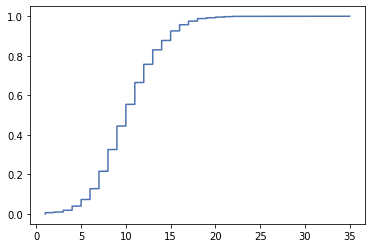

In [509]:
# plot the cdf
plt.plot(ecdf2.x, ecdf2.y)
plt.show()

In [510]:
def draw_patient_inflow():
    draw_unif = np.random.uniform()
    
    key = -1
    for k in patient_inflow_cmf.keys():
        if draw_unif > k:
            key = k
    draw = patient_inflow_cmf[key]+1
    
    return(draw)

In [511]:
temp = []
for i in range(10):
        temp.append(draw_patient_inflow())
print(temp)

[15, 10, 13, 8, 15, 13, 10, 18, 9, 6]


In [512]:
b = []
for i in range(10):
    b.append(draw_patient_inflow())
print(b)

[12, 10, 14, 5, 11, 14, 10, 9, 12, 10]


In [513]:
def get_location(x):
    if x['careunit__CSRU'] == 1: return 'CSRU'
    elif x['careunit__MICU'] == 1: return 'MICU'
    elif x['careunit__SICU'] == 1: return 'SICU'
    elif x['careunit__TSICU'] == 1: return 'TSICU'
    else: return "Other"

## Model Run

In [571]:
class MyActivation(BaseScheduler):

    def step(self) -> None:
        """ Executes the step of all agents, one at a time, in
        random order.

        """
        for agent in self.agent_buffer(shuffled=True):
            agent.step()
        self.steps += 1
        self.time += 1
        
    def advance(self) -> None:
        for agent in self.agent_buffer(shuffled=True):
            agent.advance()

In [623]:
class PatienFlowModel(Model):
    '''Simple model for running models with a finite life'''
    def __init__(self, n_agents=20, max_agents=50, n_doctors=3, n_nurses=250,service_level=1): #agent_LOS,
        super().__init__()
        
        self.n_agents = n_agents
        self.max_agents = max_agents
        self.n_doctors = n_doctors
        self.n_nurses = n_nurses
        self.max_cap_by = 0
        self.max_cap_daily = 0
        self.service_level = service_level
        self.caretime_doctors = 0
        self.caretime_nurses = 0
        self.count_discharges = 0
        self.count_deaths = 0
        self.demand_serviced = 0
                
        # keep track of the the remaining life of an agent and
        # how many ticks it has seen
        self.datacollector = DataCollector(model_reporters={"agent_count":lambda m: m.schedule.get_agent_count(),
                                                           "max_cap_by":lambda m: m.max_cap_by,
                                                           "max_cap_daily":lambda m: m.max_cap_daily,
                                                           "count_discharges":lambda m: m.count_discharges,
                                                           "count_deaths":lambda m: m.count_deaths,
                                                           "demand_serviced":lambda m: m.demand_serviced},
            agent_reporters={"out_flag": lambda a: a.out_flag,
                             "days_in_hospital": lambda a: a.steps, # +1 Because if prediction of out_flag is 0 or -1, then LOS is 1 not 0
                            "info": lambda a: a.info,
                            "NPI": lambda a: a.NPI,
                            "Careunit": lambda a: a.careunit,
                            "cum_caretime_doctors": lambda a: a.caretime_doctors,
                            "cum_caretime_nurses": lambda a: a.caretime_nurses}) 

        self.current_ID = 0
        self.schedule = MyActivation(self)

        for _ in range(self.n_agents):
            # Set seed here
            prior_steps = np.random.randint(low=1,high=4,size=1)[0] #Should be a random draw
            self.schedule.add(PatienFlowAgent(self.next_id(),self,prior_steps))

    def step(self):
        '''Add agents back to n_agents in each step'''
#         self.datacollector.collect(self)
#         self.schedule.step()
        
        # Here we define how many new agents/patients are drawn from ECDF(based on empirical distribution from real data)
        new_patients = draw_patient_inflow()

        if len(self.schedule.agents) + new_patients <= round(self.service_level * self.max_agents):
            for _ in range(new_patients):
                self.schedule.add(PatienFlowAgent(self.next_id(),self))
            self.max_cap_daily = 0
        elif len(self.schedule.agents) < round(self.service_level * self.max_agents):
            new_patients_2 = round(self.service_level * self.max_agents) - len(self.schedule.agents)
            for _ in range(new_patients_2):
                self.schedule.add(PatienFlowAgent(self.next_id(),self))    
            self.max_cap_daily = new_patients - new_patients_2
            self.max_cap_by += self.max_cap_daily
        else:
            self.max_cap_daily = new_patients
            self.max_cap_by += self.max_cap_daily
            
        self.caretime_doctors = self.n_doctors/len(self.schedule.agents)
        self.caretime_nurses = self.n_nurses/len(self.schedule.agents)
        
        self.schedule.step()
        self.datacollector.collect(self)
        self.schedule.advance()

        self.demand_serviced = 1-self.max_cap_by/(len(self.schedule.agents)+self.max_cap_by+self.count_discharges+self.count_deaths)

    def run_model(self, step_count=100):
        for _ in range(step_count):
            self.step()


class PatienFlowAgent(Agent):
    '''An agent that is supposed to live for a finite number of ticks.
    Also has a 10% chance of dying in each tick.
    '''
    def __init__(self, unique_id, model, prior_steps=0): #LOS, 
        super().__init__(unique_id, model)
        self.steps = prior_steps
        self.model = model
         # Simulation of new agents
        self.info = simulate(1, df2, df3, df6, X_train, age_cmf, od_40,od_40_64,od_65_89,od_89, diagnosis_encoder, col_ord)
        self.info['cum_caretime_doctors'] = 0
        self.info['cum_caretime_nurses'] = 0
        self.caretime_doctors = 0
        self.caretime_nurses = 0
        self.NPI = 3
        self.careunit = self.info.apply(get_location, axis=1)[0]
        self.out_flag = 0
        
    def step(self):
            curr_info = self.info.loc[[self.steps]]
            self.caretime_doctors += self.model.caretime_doctors
            self.caretime_nurses  += self.model.caretime_nurses
            curr_info['cum_caretime_doctors'] += self.caretime_doctors
            curr_info['cum_caretime_nurses'] += self.caretime_nurses
#             self.info.loc[[self.steps+1]]['cum_caretime_doctors'] += curr_info['cum_caretime_doctors']
#             self.info.loc[[self.steps+1]]['cum_caretime_nurses'] += curr_info['cum_caretime_nurses']
#             curr_info['COUNT_PATIENTS'] = len(self.model.schedule.agents)
#             self.info['days_since_admission'] = self.steps
            self.NPI = self.model.n_nurses / len(self.model.schedule.agents)
            self.careunit = self.info.apply(get_location, axis=1)[0]
            self.out_flag = prediction_svm(curr_info,False)[0] #forest.predict(self.info)[0]
            # This part is to correct for very short-term releases that occur too often:
            if self.out_flag != 0 and self.steps < 4:
                draw = np.random.binomial(1,0.5)
                if draw==0:
                    self.out_flag = 0
            
            self.steps += 1  # keep track of how many ticks are seen
            
            #if np.random.binomial(1, 0.1) != 0:  # 10% chance of dying
#             if  self.out_flag == 1 or self.out_flag == 2: #  When the patient is discharged/passes away, remove from model
#                 self.model.schedule.remove(self)
                
    def advance(self):
        #if  self.out_flag == 1 or self.out_flag == 2: #  When the patient is discharged/passes away, remove from model
            #self.model.schedule.remove(self)
        if self.out_flag == 2:
            self.model.count_discharges +=1
            self.model.schedule.remove(self)
        if self.out_flag == 1:
            self.model.count_deaths +=1
            self.model.schedule.remove(self)

            
            
            
class TestAgentLifespan(unittest.TestCase):
    def setUp(self):
        self.model = LifeTimeModel()
        self.model.run_model()
        self.df = self.model.datacollector.get_agent_vars_dataframe()
        self.df = self.df.reset_index()

    def test_ticks_seen(self):
        '''Each agent should be activated no more than one time'''
        assert self.df.steps.max() == 1

    def test_agent_lifetime(self):
        lifetimes = self.df.groupby(["AgentID"]).agg(
            {"Step": lambda x: len(x)})
        assert lifetimes.Step.max() == 2


#if __name__ == '__main__':
#    unittest.main()

In [624]:
model = PatienFlowModel(n_agents=30,max_agents=50,n_doctors=3,n_nurses=300)
for i in range(20):
    print(i)
    model.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


## Agent Results from Model Run

In [625]:
temp2 = model.datacollector.get_agent_vars_dataframe()
temp2

out_flag  days_in_hospital  \
Step AgentID                               
1    1               0                 4   
     2               2                 3   
     3               2                 4   
     4               0                 2   
     5               0                 4   
...                ...               ...   
20   228             0                 1   
     229             2                 1   
     230             1                 1   
     231             2                 1   
     232             0                 1   

                                                           info       NPI  \
Step AgentID                                                                
1    1              age preiculos  gcs heartrate meanbp resp...  7.142857   
     2              age preiculos  gcs heartrate meanbp resp...  7.142857   
     3              age preiculos  gcs heartrate meanbp resp...  7.142857   
     4              age preiculos  gcs heartrate meanbp resp...  7.142857   
     5              age preiculos  gcs heartrate meanbp resp...  7.142857   
...                                                         ...       ...   
20   228            age preiculos  gcs heartrate meanbp resp...  6.000000   
     229            age preiculos  gcs heartrate meanbp resp...  6.000000   
     230            age preiculos  gcs heartrate meanbp resp...  6.000000   
     231            age preiculos  gcs heartrate meanbp resp...  6.000000   
     232            age preiculos      gcs heartrate  meanbp...  6.000000   

             Careunit  cum_caretime_doctors  cum_caretime_nurses  
Step AgentID                                                      
1    1           CSRU              0.071429             7.142857  
     2           MICU              0.071429             7.142857  
     3           MICU              0.071429             7.142857  
     4           SICU              0.071429             7.142857  
     5           CSRU              0.071429             7.142857  
...               ...                   ...                  ...  
20   228         MICU              0.060000             6.000000  
     229         MICU              0.060000             6.000000  
     230         CSRU              0.060000             6.000000  
     231        TSICU              0.060000             6.000000  
     232        TSICU              0.060000             6.000000  

[784 rows x 7 columns]

In [626]:
flat_info = pd.DataFrame(temp2.to_records())

cum_caretime_doctors = []
cum_caretime_nurses = []
LOS = []
for i in flat_info['AgentID'].unique():
    LOS.append(flat_info[flat_info['AgentID']==i]['days_in_hospital'].max())
    cum_caretime_doctors.append(flat_info[flat_info['AgentID']==i]['cum_caretime_doctors'].max())
    cum_caretime_nurses.append(flat_info[flat_info['AgentID']==i]['cum_caretime_nurses'].max())

In [627]:
temp3 = model.datacollector.get_model_vars_dataframe()
temp3.head(100)

,agent_count,max_cap_by,max_cap_daily,count_discharges,count_deaths,demand_serviced
0,42,0,0,0,0,0.0
1,39,0,0,13,1,1.0
2,38,0,0,23,6,1.0
3,34,0,0,33,7,1.0
4,34,0,0,39,11,1.0
5,38,0,0,44,12,1.0
6,38,0,0,52,14,1.0
7,37,0,0,57,19,1.0
8,42,0,0,62,19,1.0
9,43,0,0,71,20,1.0


## BatchRunner

In [ ]:

#fixed_params = {
 #   "n_agents": 30,
#}
parameters = {"n_doctors": [2,3], "max_agents": [80,100], "n_nurses": [150,200,250], "n_agents": [30,50,70]}
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        #fixed_params,
                        iterations=1,
                        max_steps=100,
                        model_reporters={"all":lambda m: m.datacollector})
batch_run.run_all()

26it [14:39:02, 1986.60s/it]

In [ ]:
run_data = batch_run.get_model_vars_dataframe()

In [ ]:
run_data.loc[0,'all'].get_agent_vars_dataframe()

In [ ]:
run_data.loc[0,'all'].get_model_vars_dataframe()

In [ ]:
caretime_info = pd.DataFrame(df3[['ICUSTAY_ID','cum_caretime_doctors','cum_caretime_nurses']]
                             .groupby('ICUSTAY_ID').max().to_records())

In [ ]:
LOS_info = df3[['ICUSTAY_ID','LOS']].groupby('ICUSTAY_ID').max()['LOS']

In [ ]:
LOS_info

In [ ]:
plt.plot(np.arange(0,1,1/len(LOS_info)),sorted(round(LOS_info)),color='red')

for i in range(run_data.shape[0]):
    data = run_data.loc[i,'all'].get_agent_vars_dataframe()
    flat_info = pd.DataFrame(data.to_records())
    LOS = []
    for i in flat_info['AgentID'].unique():
        LOS.append(flat_info[flat_info['AgentID']==i]['days_in_hospital'].max())   
    plt.plot(np.arange(0,1,1/len(LOS))[:len(LOS)],sorted(LOS),color='blue',alpha=0.3)

plt.ylim((0,20))
plt.xlabel('Proportion of Patients')
plt.ylabel('Length of Stay')
plt.show()

In [ ]:
plt.plot(np.arange(0,1,1/len(caretime_info['cum_caretime_doctors'])),
         sorted(caretime_info['cum_caretime_doctors']),color='red')


for i in range(run_data.shape[0]):
    data = run_data.loc[i,'all'].get_agent_vars_dataframe()
    flat_info = pd.DataFrame(data.to_records())
    cum_caretime_doctors = []
    for i in flat_info['AgentID'].unique():
        cum_caretime_doctors.append(flat_info[flat_info['AgentID']==i]['cum_caretime_doctors'].max())
        
    plt.plot(np.arange(0,1,1/len(cum_caretime_doctors))[:len(cum_caretime_doctors)],sorted(cum_caretime_doctors),color='blue',alpha=0.3)

plt.ylim((0,1.2))
plt.xlim(0,1)
plt.xlabel('Proportion of Patients')
plt.ylabel('Cumulative Doctor Caretime')
plt.show()

In [ ]:
quants = np.arange(0,1,1/len(cum_caretime_nurses)) #1/len(cum_caretime_nurses)
plt.plot(np.arange(0,1,1/len(caretime_info['cum_caretime_nurses'])),
         sorted(caretime_info['cum_caretime_nurses']),color='red')


for i in range(run_data.shape[0]):
    data = run_data.loc[i,'all'].get_agent_vars_dataframe()
    flat_info = pd.DataFrame(data.to_records())
    cum_caretime_nurses = []
    for i in flat_info['AgentID'].unique():
        cum_caretime_nurses.append(flat_info[flat_info['AgentID']==i]['cum_caretime_nurses'].max())
    plt.plot(quants,np.quantile(sorted(cum_caretime_nurses),quants),color='blue',alpha=0.3)

plt.ylim((0,125))
plt.xlabel('Proportion of Patients')
plt.ylabel('Cumulative Nurse Caretime')
plt.show()

In [ ]:
mortality_LOS_info = pd.DataFrame(df3[['ICUSTAY_ID','HOSPITAL_EXPIRE_FLAG','LOS']]
                             .groupby('ICUSTAY_ID').max().to_records())

In [ ]:
# Getting LOS only of those cases where patients passes away
mortality_LOS_info2 = mortality_LOS_info[mortality_LOS_info['HOSPITAL_EXPIRE_FLAG']==1]

In [ ]:
plt.plot(np.arange(0,1,1/len(mortality_LOS_info2['LOS'])),
         sorted(round(mortality_LOS_info2['LOS'])),color='red',label="Actual All",alpha=0.3)

for i in range(run_data.shape[0]):
    data = run_data.loc[i,'all'].get_agent_vars_dataframe()
    flat_info = pd.DataFrame(data.to_records())
    flat_info2 = flat_info[flat_info['out_flag']==2] # Fatalities
    LOS = []
    for i in flat_info2['AgentID'].unique():
        LOS.append(flat_info2[flat_info2['AgentID']==i]['days_in_hospital'].max())   
    plt.plot(np.arange(0,1,1/len(LOS))[:len(LOS)],sorted(LOS),color='blue',alpha=0.3)
    #plt.plot(np.arange(0,1,1/len(flat_info2.days_in_hospital)),sorted(round(flat_info2.days_in_hospital)),color='blue',label="ABM ALL",alpha=0.3)

plt.ylim((0,20))
plt.xlabel('Proportion of Patients')
plt.ylabel('Length of Stay (of Fatalities)')
plt.show()

In [ ]:
flat_info2 = flat_info[flat_info['out_flag']==2] # Fatalities
flat_info3 = flat_info[flat_info['out_flag']==1] # Discharge

plt.style.use('seaborn-deep')
x = flat_info2.days_in_hospital
y = flat_info3.days_in_hospital
x_w = np.empty(x.shape)
x_w.fill(1/x.shape[0])
y_w = np.empty(y.shape)
y_w.fill(1/y.shape[0])
bins = np.linspace(0, 50, 30)

plt.hist([x, y], bins,weights=[x_w, y_w], label=['Mortalities', 'Discharges'])
plt.xlim((0,30))
#plt.ylim((0,0.95))
plt.legend(loc='upper right')
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Zoomed In for better Analysis
plt.hist([x, y], bins,weights=[x_w, y_w], label=['Mortalities', 'Discharges'])
plt.xlim((0,30))
plt.ylim((0,0.90))
plt.legend(loc='upper right')
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')
plt.show()

In [ ]:
unit_count = []
for i in flat_info['Step'].unique():
    unit_count.append(flat_info[flat_info['Step']==i]['Careunit'].value_counts().to_dict())

unit_count = pd.DataFrame(unit_count)

In [ ]:
plt.plot(unit_count['MICU'],label = "MICU")
plt.plot(unit_count['SICU'],label = "SICU")
plt.plot(unit_count['CSRU'], label = "CSRU")
plt.plot(unit_count['TSICU'], label = "TSICU")
plt.xlabel('Days of Simulation')
plt.ylabel('Number of beds occupied')
plt.legend()
plt.show()

In [ ]:
def normalize(x):
        return (x - x.min(0)) / x.ptp(0)

In [ ]:
pd.Series(count_LOS).hist(bins=32, normed=True,grid=False)

In [ ]:
flat_info

In [ ]:
flat_info['info'][0]#[1]
#flat_info['info']

In [ ]:
flat_info[flat_info['out_flag']==1][:50] # Fatalities

In [ ]:
plt.figure(figsize=(20,10))
import seaborn as sns
# Reference Data:
fatal_df=df6[df6["HOSPITAL_EXPIRE_FLAG"]==1] # Fatalities

#ABM Data:
count_deaths_series =[]
for i in range(run_data.shape[0]):
    data = run_data.loc[i,'all'].get_agent_vars_dataframe()
    flat_info = pd.DataFrame(data.to_records())
    flat_info2 = flat_info[flat_info['out_flag']==1] # Fatalities
    count_LOS =[]
    #for j in range(0,len(flat_info2)):
        #count_LOS.append(list(flat_info2.days_in_hospital)[j])
    for i in flat_info2['AgentID'].unique():
        count_LOS.append(flat_info2[flat_info2['AgentID']==i]['days_in_hospital'].max()) 
    sns.kdeplot(count_LOS, bw=.6, label="bw: 0.6",color='grey')
    #sns.distplot(count_LOS,hist = False, kde = True,
    #             kde_kws = {'shade': True, 'linewidth': 1},color='grey',label='ABM Simulation')
sns.kdeplot(round(fatal_df["LOS"]), bw=.6, label="bw: 0.6",color='blue')
#sns.distplot(round(fatal_df["LOS"]),hist = False, kde = True,
   #         kde_kws = {'shade': True, 'linewidth': 1},color='blue',label='Actual Data')

#plt.xlim((30,50))
#plt.ylim((0.8,1))
plt.title('Density Plot with Multiple Simulations')
plt.xlabel('LOS(days) of patients who passed away')
plt.ylabel('Density')
plt.legend()
plt.show()

# EVERYTHING BEYOND HERE IS NOT NECESSARY FOR MY ANALYSES

### Confidence Intervals for Discharges and Deaths [DELETE]

In [ ]:
## TAKES A LONG TIME TO RUN!!

# --------

#n = 30 # number of iterations of model run
#discharges_all =[]
#deaths_all =[]
#for j in range(n):
    #Run the model
#    model = PatienFlowModel(n_agents=20)
#    for i in range(50):
#        model.step()
#    temp4 = model.datacollector.get_model_vars_dataframe()
#    count_discharges= [temp4["count_discharges"]]
#    count_deaths = [temp4["count_deaths"]]
#    discharges_all.append(count_discharges)
 #   deaths_all.append(count_deaths)
    
#Create a dataframe of all runs and plot simulations
#df_overall = pd.DataFrame()
#for i in range(0,len(discharges_all)):
#    df_temp = pd.DataFrame(discharges_all[i]).T
#    df_overall= pd.concat([df_overall,df_temp],axis=1)

#plt.plot(df_overall,alpha=0.3)
#plt.show()

#df_overall2 = pd.DataFrame()
#for i in range(0,len(deaths_all)):
#    df_temp2 = pd.DataFrame(deaths_all[i]).T
#    df_overall2= pd.concat([df_overall2,df_temp2],axis=1)

#plt.plot(df_overall2,alpha=0.3)
#plt.show()

### Daily-Exceeding Capacity [UPDATE]

Given a max_capacity in the ICU which has been defined in the model this plot can be used to figure out the point in time, where new **patients** can not be admitted to the ICU anymore and **need to be transfered to another hospital**. The basic model assumes a 100% service level for capacity, however further below a batch-model is presented, where for different service levels the same information can be retrieved.

In [ ]:
#count = 0
#for i in temp3["max_cap_daily"]:
#    if i!=0:
#        count +=1
#print(count)

In [ ]:
avg = sum(temp3["max_cap_daily"])/len(temp3["max_cap_daily"])
plt.plot(temp3.index,temp3["max_cap_daily"], label = "Daily Exceeding")
plt.plot(temp3.index,[avg for i in range(0,len(temp3))], label = "Average")
plt.plot(temp3.index,temp3["new_patients_demand"], label = "Patient Inflow (Demand)")
plt.legend()
plt.show()

### Nurse-Patient-Interaction [DELETE]

In [ ]:
# Taking the Sum of All Nurse to Patient interaction ratios (proxy for interaction time)
NPI = []
for i in flat_info['AgentID'].unique():
    NPI.append(flat_info[flat_info['AgentID']==i]['NPI'].sum())

NPI

In [ ]:
# This is supposed to show that the higher the sum of NPI ratios (x-axis), the higher the LOS
plt.scatter(NPI,LOS)

### Careunit Analysis

In [ ]:
flat_info = pd.DataFrame(temp2.to_records())

unit_count = []
for i in flat_info['Step'].unique():
    unit_count.append(flat_info[flat_info['Step']==i]['Careunit'].value_counts().to_dict())

unit_count = pd.DataFrame(unit_count)

In [ ]:
plt.plot(unit_count['MICU'],label = "MICU")
plt.plot(unit_count['SICU'],label = "SICU")
plt.plot(unit_count['CSRU'], label = "CSRU")
plt.plot(unit_count['TSICU'], label = "TSICU")
plt.legend()
plt.show()

### Fatalities per Day (Absolute and Percentage) [DELETE]

In [ ]:
flat_info = pd.DataFrame(temp2.to_records())

unit_count = []
for i in flat_info['Step'].unique():
    unit_count.append(flat_info[flat_info['Step']==i]['out_flag'].value_counts().to_dict())

unit_count
unit_count = pd.DataFrame(unit_count)

In [ ]:
# plt.plot(unit_count[0],label = "Count_Stays")
#plt.plot(unit_count[1],label = "Count_Discharges")
plt.plot(unit_count[2], label = "Count_Fatalities") #There are currently no death predictions
plt.legend()
plt.show()

In [ ]:
# Vital Analysis

In [ ]:
#flat_info["info"][0]["heartrate"]

In [ ]:
#flat_info["info"][0]

In [ ]:
#flat_info = pd.DataFrame(temp2.to_records())

#vital_A = []
#for i in flat_info['AgentID'].unique():
 #   vital_A.append(flat_info["info"][0][flat_info['AgentID']==3]["heartrate"])

#vital_A

## Model  Results from Model Run

### Number of Agents in the Model per Step

In [ ]:
# I think this does 100 steps for each agent --> range(20)
#for j in range(100):
    # Run the model
#    model = PatienFlowModel(n_agents=20)
#    for i in range(20):
#        model.step()
        
#model_df = model.datacollector.get_model_vars_dataframe()
#n_agents = [model_df["agent_count"]]
#n_agents = [a.unique_id for a in model.schedule.agents]
#plt.hist(n_agents,bins=10)
#plt.show()

### Capturing Capacity Excess (max_cap_by)

## Batch Runner for different service levels

In [ ]:

fixed_params = {
    "max_agents": 100,
}
parameters = {"service_level": [0.75 , 0.8 , 0.85 , 0.9 , 0.95 , 1]}
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        fixed_params,
                        iterations=2,
                        max_steps=80,
                        model_reporters={"max_cap_by":lambda m: m.max_cap_by})
batch_run.run_all()

## Batch Runner for different number of agents

In [ ]:

fixed_params = {
    "max_agents": 100,
}
parameters = {"n_agents": range(10, 100, 5)}
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        fixed_params,
                        iterations=5,
                        max_steps=100,
                        model_reporters={"max_cap_by":lambda m: m.max_cap_by})
batch_run.run_all()

In [ ]:
run_data = batch_run.get_model_vars_dataframe()
#run_data.head()
plt.scatter(run_data.n_agents, run_data.max_cap_by)
plt.xlabel('n_agents', fontsize=15)
plt.ylabel('Capacity Excess', fontsize=15)

In [ ]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import pickle

import xgboost as xgb

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection  import ParameterGrid
from sklearn import preprocessing
from sklearn.cluster import KMeans

# set seed
SEED=3642
np.random.seed(SEED)

In [ ]:
X_train

In [ ]:
from sklearn.metrics import r2_score

def get_models():
    #Generate a library of simple learners
    #svr = SVR(C=1, gamma= 0.25)
    #knn = KNeighborsRegressor(n_neighbors=5)
    lr = LogisticRegression(C=100, random_state=SEED, solver='newton-cg', max_iter=1000)
    #rf = RandomForestRegressor(n_estimators=30, max_features=10, random_state=SEED)
    gb = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1)
    
    #gb = xgb.XGBRegressor(colsample_bytree= 0.7, 
                            #learning_rate= 0.07, 
                          #max_depth= 7, 
                         # min_child_weight= 4,
                          #n_estimators= 90, 
                          #nthread= 3, 
                          #objective= 'reg:linear', 
                         # silent= 1, 
                          #subsample= 0.7)

    models = {#'svm': svr,
              #'knn': knn,
              #'random forest': rf,
              #'logistic': lr,
              'Xboost Classifier': gb
              }

    return models


def train_predict(model_list,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
    #Fit models in list on training set and return preds
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(X_train, y_train)
        P.iloc[:, i] = m.predict_proba(X_test)[:, 1]
        #P.iloc[:, i] = m.predict(X_test)
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
     # Score model in test set
    print("Scoring models.")
    #mse_scores=[]
    #r2_scores=[]
    auc_score=[]
    
    for m in P.columns:
        #score = mean_squared_error(y, P.loc[:, m])
        score = get_auc(y_test,  P.iloc[:, m],[0,1],column=1, plot=False)
        auc_scores.append(score)
        r2_score_temp = r2_score(y, P.loc[:, m])
        r2_scores.append(r2_score_temp)
        print("%-26s: MSE: %.3f R^2: %.3f" %(m, score, r2_score_temp))
    return P.columns, auc_scores, r2_scores

In [ ]:
gb_fit = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1).fit(X_train,y_train)
get_auc(y_test, gb_fit.predict_proba(X_test),[0,1], column=1, plot=True)

In [ ]:
models = get_models()
P = train_predict(models,X_train,y_train,X_test,y_test)
my_models, auc_scores, r2_scores= score_models(P, y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

MyXGB = xgb.XGBClassifier() #objective='reg:squarederror'
parameters = {'nthread':[3], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [90]}

grid_knn_acc = GridSearchCV(MyXGB, param_grid = parameters, scoring = 'r2', cv=5, refit=True,n_jobs=3)
grid_knn_acc.fit(X, y)

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=140, 
                                                  max_depth=5,min_child_weight=1, gamma=0, subsample=0.8, 
                                                  colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                                                  scale_pos_weight=1,seed=27), param_grid = param_test1, 
                                                  scoring='roc_auc',n_jobs=2,cv=5)
gsearch1.fit(X_train,y_train)
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
main_df2 = pd.read_csv('main_df2.csv')

In [ ]:
plt.hist(main_df2["SEQ_NUM"],bins=40)